In [ ]:
import sys 
import numpy as np
import math
import numba
from numba import cuda, int64, jit
from numba.cuda import random as rnd
from timeit import default_timer as timer
from scipy.stats import binom, poisson
import pickle as pkl
import os
os.system("ml CUDA")

0

We will decode our genome as follows 00: A, 01: C, 10: G, 11: T. We will use unsinged integers with 64 bit. (numpy uint64). So 32 letters can be stored in one int. We will use 2*L ints in order to encode L*64 letters. In our example we have a genome length of 640000 letters times N cells (between 100 and 400). 

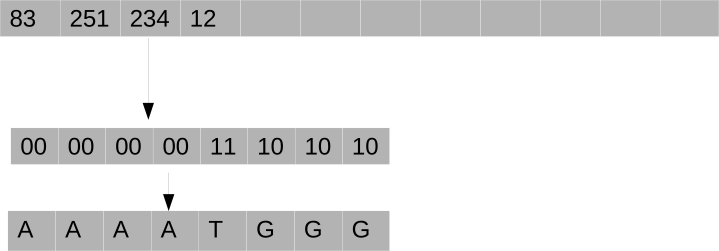



Here we have a little helper function for transforming our binary encoded genomes into a more human readable version. 

In [ ]:
def transformAlignment(genotypes):
    N=int(genotypes.shape[0])
    L=int(genotypes.shape[1])
    alignment=[]
    for pos in range(0,L*64,2):
        posInt = pos//64
        posInInt = pos%64
        variant=[]
        for i in range(N):
            if int(genotypes[i,posInt]) & 2**posInInt == 0 and int(genotypes[i,posInt]) & 2**(posInInt+1) == 0:
                 variant.append("A")
            elif int(genotypes[i,posInt]) & 2**posInInt == 0 and int(genotypes[i,posInt]) & 2**(posInInt+1) > 0:
                 variant.append("C")
            elif int(genotypes[i,posInt]) & 2**posInInt > 0 and int(genotypes[i,posInt]) & 2**(posInInt+1) == 0:
                 variant.append("G")
            else:
                 variant.append("T")
        alignment.append(variant)
    return(alignment)

We are using a simple Kernel which only runs once to sum our fitnesses. Alternatively, we would have to copy the fitness array to the main memory and do the sum via the CPU. 

In [ ]:
@cuda.jit
def sumF(fitnessarr,F):
    F[0]=0
    for i in range(fitnessarr.shape[0]):
        F[0]+=fitnessarr[i]

Let's see how we can use ints and bit operations to store and manipulate large amounts of data on a GPU. Our genome is made up of letters of a 4 letter alphabet (ACGT). Most efficient storage is using two bits per letter. For mutations we would like to get a transition:transversion ratio of 1:3. 

In [ ]:
@cuda.jit
def mutate(gen,genotypes,reference,fitnessarr,F,s):
    cellID = cuda.grid(1)
    genoblocks = genotypes.shape[1]/2
    L=64*genoblocks
    N=genotypes.shape[0]
    if cellID < N:
        #add mutations
        numberMutations=5
        for i in range(numberMutations):
            #for simplicity and demonstration purposes we cluster all mutations in generation gen in the genth int (bitblock) and mutate the first five letters
            posInt = cellID
            posInInt = 2*(5*gen+i)%32
            #this will give a transition:transversion ratio of 1:3 on average
            r=((cellID+i*N/4)%N)/N
            if r < 1/4:
                #transverion (first bit with probability 1/2)
                if r < 1/8:
                    genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**posInInt
                #second bit has to be flipped
                genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**(posInInt+1)
            else:
                #transition (00<->10 or 01<->11)
                genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**posInInt
        #not we are gonna count the mutations, i.e., mismatches with the reference
        snpCount=0
        for posInt in range(genoblocks):
            intAnd=(genotypes[cellID,posInt] ^ reference[posInt])
            for posInInt in range(0,64,2):
                if intAnd & 2**posInInt > 0 or intAnd & 2**(posInInt+1) > 0:
                    snpCount+=1
        fitnessarr[cellID]=s**snpCount
    cuda.syncthreads()

In [ ]:
L=10000
n=64*L

threadsperblock = 20
blocks = 20

N=threadsperblock*blocks
s=0.999
SEED=1
NUMCYCLES=8*N

genotypes = np.array(np.reshape(np.array(list(np.random.randint(0,2**64, L*2,dtype=np.uint64))*2*N),(N,L*4)), dtype=np.uint64)
devgenotypes = cuda.to_device(genotypes)
reference = np.copy(genotypes[0,:])
devreference = cuda.to_device(reference)

fitnessarr = np.ones(N)
F=np.sum(fitnessarr)
devfitnessarr=cuda.to_device(fitnessarr)
F=cuda.device_array((1))
sumF[1,1](devfitnessarr,F)

In [ ]:
start = timer()
mutate[blocks, threadsperblock](0,devgenotypes,devreference,devfitnessarr,F,s)
sumF[1,1](devfitnessarr,F)
cuda.synchronize()
evolve_time=timer()-start
print("first iteration: "+str(evolve_time))
fitnessarr = devfitnessarr.copy_to_host()
print(fitnessarr[:10])
genotypes = devgenotypes.copy_to_host()
alignment = transformAlignment(genotypes[:20,:3])
x=[print("".join(row)) for row in np.array(alignment).T]

first iteration: 1.2495027149561793
[0.99500999 0.99500999 0.99500999 0.99500999 0.99500999 0.99500999
 0.99500999 0.99500999 0.99500999 0.99500999]
ATATGTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACCGATCCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACCGCCCGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTA

In [ ]:
start = timer()
mutate[blocks, threadsperblock](1,devgenotypes,devreference,devfitnessarr,F,s)
sumF[1,1](devfitnessarr,F)
cuda.synchronize()
evolve_time=timer()-start
print("second iteration: "+str(evolve_time))
fitnessarr = devfitnessarr.copy_to_host()
print(fitnessarr[:10])
genotypes = devgenotypes.copy_to_host()
alignment = transformAlignment(genotypes[:20,:3])
x=[print("".join(row)) for row in np.array(alignment).T]

second iteration: 0.3677309589693323
[0.99004488 0.99004488 0.99004488 0.99004488 0.99004488 0.99004488
 0.99004488 0.99004488 0.99004488 0.99004488]
ATATGATTGGTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACCGATCGGGGCAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACCGCCCCAAAAACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGT

In [ ]:
start = timer()
for i in range(2,102):
    mutate[blocks, threadsperblock](i,devgenotypes,devreference,devfitnessarr,F,s)
    sumF[1,1](devfitnessarr,F)
cuda.synchronize()
evolve_time=timer()-start
print("100 more iterations: "+str(evolve_time))
fitnessarr = devfitnessarr.copy_to_host()
print(fitnessarr[:10])
genotypes = devgenotypes.copy_to_host()
alignment = transformAlignment(genotypes[:20,:3])
x=[print("".join(row)) for row in np.array(alignment).T]

100 more iterations: 36.91937435301952
[0.99202794 0.99202794 0.99202794 0.99202794 0.99202794 0.99202794
 0.99202794 0.99202794 0.99202794 0.99202794]
GCGACGCCCCGGGTAGATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACTAGAGAAACGCGTTACAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACTATGGTGGTTCCATTTAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGGGTACAGAAAAACAGATGCATAGCC
TCGCCTCCACTGGGTCATGCCTATCAGAGGACGAGCGCAAAGAGTGTGAGCGTACTTCCGGTACGATTGGGG

Let's compare doing the sum on the GPU vs copying and summing on the CPU.

In [ ]:
mutate[blocks, threadsperblock](1,devgenotypes,devreference,devfitnessarr,F,s)
cuda.synchronize()
start = timer()
sumF[1,1](devfitnessarr,F)
cuda.synchronize()
sum_time=timer()-start
print("sum on GPU: "+str(sum_time))
mutate[blocks, threadsperblock](1,devgenotypes,devreference,devfitnessarr,F,s)
cuda.synchronize()
start = timer()
fitnessarr = devfitnessarr.copy_to_host()
Flocal=np.sum(fitnessarr)
cuda.synchronize()
sum_time=timer()-start
print("sum on CPU: "+str(sum_time))

sum on GPU: 0.0005987789481878281
sum on CPU: 0.0003633219748735428
